## Credit Risk Resampling Techniques

In [61]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Import dependences
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced

In [63]:
# Show all the columns of dataframe
pd.set_option('display.max_columns', None)

## Read the CSV and Perform Basic Data Cleaning

In [64]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

## Create Data Frame

In [65]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head(5)

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,w,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,May-2019,0.0,1.0,Individual,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,w,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,May-2019,0.0,1.0,Individual,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,w,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,May-2019,0.0,1.0,Individual,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,w,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,May-2019,0.0,1.0,Individual,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,w,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,May-2019,0.0,1.0,Individual,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [66]:
# Create our features
X = df.drop("loan_status", axis=1)
X= pd.get_dummies(X)
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,0.0,1.0,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,0.0,1.0,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,0.0,1.0,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,0.0,1.0,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,0.0,1.0,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,1,1,0,1,1


In [67]:
# Create our target
y = df["loan_status"]

In [68]:
# Describe the matrix X
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000,68817.0,68817.0,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.00000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,24.666347,16018.845833,16015.919519,970.639473,970.431151,658.748750,311.855687,0.035072,0.0,0.0,517.202218,0.016188,1.0,0.0,188.664298,1.634976e+05,1.023047,3.290481,0.843730,1.909644,14.303152,4.324044e+04,69.21191,1.240042,2.622245,6297.491710,55.702472,42431.895360,1.382071,1.687795,2.189023,4.827572,14142.936193,16991.852667,48.330667,0.006830,2.347065,125.468605,175.136841,14.294215,7.179781,1.441882,24.714954,7.688028,0.472485,3.806123,5.648038,5.135156,7.414403,9.500153,8.630818,13.517663,5.653036,12.571995,0.0,0.0,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,0.009285,0.526309,0.106747,0.357659,0.478007,0.373992,0.148001,0.371696,0.451066,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,12.318917,10002.695495,10004.985940,1229.563301,1229.569864,1126.237377,279.786954,1.086720,0.0,0.0,816.021053,0.134774,0.0,0.0,1808.457195,1.723699e+05,1.176782,2.965579,0.970543,1.544994,13.972619,4.956130e+04,22.33711,1.471745,2.502608,5702.281757,18.495480,37166.229316,1.543220

In [69]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [71]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)

In [72]:
# Fit the model and count re_sampled
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [73]:
# Logistic regression using random oversampled data
classifier1 = LogisticRegression(solver='lbfgs', random_state=1)

In [74]:
# Fit the classifier
classifier1.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

## Making Predictions Using the Testing Data

In [75]:
# Display the confusion matrix
y_pred = classifier1.predict(X_test)
y_pred

array(['high_risk', 'high_risk', 'low_risk', ..., 'high_risk',
       'high_risk', 'low_risk'], dtype=object)

## Classifier Evaluation

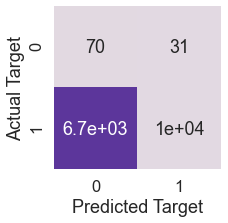

In [76]:
# Calculate the confusion matrix
#confusion_matrix(y_test, y_pred)

# Define a function to create a nicer looking confusion matrix
# Import seaborn as sns
sns.set(font_scale=1.5)
def plot_confusion_matrix(y_test,y_pred):
    fig,ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="twilight_r")
    plt.xlabel("Predicted Target")
    plt.ylabel("Actual Target")
plot_confusion_matrix(y_test, y_pred)

In [77]:
# Calculate the balanced accuracy score
print("balanced_accuracy_score:")
balanced_accuracy_score(y_test, y_pred)

balanced_accuracy_score:


0.6503524738582371

In [78]:
# Print the imbalanced classification report
print("classification_report_imbalanced:")
print(classification_report_imbalanced(y_test, y_pred))

classification_report_imbalanced:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.61      0.02      0.65      0.42       101
   low_risk       1.00      0.61      0.69      0.76      0.65      0.42     17104

avg / total       0.99      0.61      0.69      0.75      0.65      0.42     17205



### SMOTE Oversampling

In [79]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [80]:
# Train the Logistic Regression model using the resampled data
classifier2 = LogisticRegression(solver='lbfgs', random_state=1)
classifier2.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

## Making Predictions Using the Testing Data

In [81]:
# Calculate the balanced accuracy score
y_pred = classifier2.predict(X_test)
y_pred

array(['low_risk', 'high_risk', 'low_risk', ..., 'high_risk', 'low_risk',
       'low_risk'], dtype=object)

## Classifier Evaluation

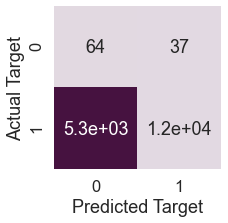

In [82]:
# Calculate the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [83]:
# Calculate the balanced accuracy score
print("balanced_accuracy_score:")
balanced_accuracy_score(y_test, y_pred)

balanced_accuracy_score:


0.6621602612787003

In [84]:
# Print the imbalanced classification report
print("classification_report_imbalanced:")
print(classification_report_imbalanced(y_test, y_pred))

classification_report_imbalanced:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.63      0.69      0.02      0.66      0.44       101
   low_risk       1.00      0.69      0.63      0.82      0.66      0.44     17104

avg / total       0.99      0.69      0.63      0.81      0.66      0.44     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [99]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 246, 'low_risk': 246})

In [88]:
# Train the Logistic Regression model using the resampled data
classifier3 = LogisticRegression(solver='lbfgs', random_state=1)
classifier3.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

## Making Predictions Using the Testing Data

In [89]:
y_pred = classifier3.predict(X_test)
y_pred

array(['high_risk', 'low_risk', 'high_risk', ..., 'high_risk',
       'high_risk', 'high_risk'], dtype=object)

## Classifier Evaluation

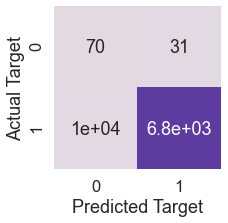

In [90]:
# Calculate the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [91]:
# Calculate the balanced accuracy score
print("balanced_accuracy_score:")
balanced_accuracy_score(y_test, y_pred)

balanced_accuracy_score:


0.5442661782548694

In [92]:
# Print the imbalanced classification report
print("classification_report_imbalanced:")
print(classification_report_imbalanced(y_test, y_pred))

classification_report_imbalanced:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.40      0.01      0.52      0.28       101
   low_risk       1.00      0.40      0.69      0.57      0.52      0.27     17104

avg / total       0.99      0.40      0.69      0.56      0.52      0.27     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [93]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'high_risk': 68458, 'low_risk': 62022})

In [94]:
# Train the Logistic Regression model using the resampled data
classifier4 = LogisticRegression(solver='lbfgs', random_state=1)
classifier4.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

## Making Predictions Using the Testing Data

In [95]:
y_pred = classifier4.predict(X_test)
y_pred

array(['high_risk', 'low_risk', 'low_risk', ..., 'high_risk', 'high_risk',
       'low_risk'], dtype=object)

## Classifier Evaluation

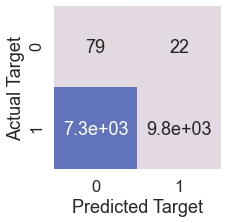

In [96]:
# Calculate the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [97]:
# Calculate the balanced accuracy score
print("balanced_accuracy_score:")
balanced_accuracy_score(y_test, y_pred)

balanced_accuracy_score:


0.6774256383776824

In [98]:
# Print the imbalanced classification report
print("classification_report_imbalanced:")
print(classification_report_imbalanced(y_test, y_pred))

classification_report_imbalanced:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.78      0.57      0.02      0.67      0.46       101
   low_risk       1.00      0.57      0.78      0.73      0.67      0.44     17104

avg / total       0.99      0.57      0.78      0.72      0.67      0.44     17205

